# Car accident

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import chardet
import datetime
import os
from tueplots import bundles
from tueplots.constants.color import rgb
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, HDBSCAN
import seaborn as sns
import geopandas
import contextily as cx


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})
plt.rcParams["axes.unicode_minus"] = False

if not os.path.exists('Graphen'):
    os.mkdir('Graphen')
if not os.path.exists('Daten'):
    os.mkdir('Daten')

In [14]:
import matplotlib.font_manager

In [6]:
# Import accident datasets
# https://www.nhtsa.gov/file-downloads?p=nhtsa/downloads/FARS/2020/National/
# Adjust nrows only for testing purposes (faster testing of new code)
path = 'Daten/FARS2021NationalCSV/'
nrows = None

accidents = pd.read_csv(path + 'accident.csv',encoding='WINDOWS-1252',nrows=nrows)
drimpair = pd.read_csv(path + 'drimpair.csv',encoding='WINDOWS-1252',nrows=nrows)
driverrf = pd.read_csv(path + 'driverrf.csv',encoding='WINDOWS-1252',nrows=nrows)
vehicle = pd.read_csv(path + 'vehicle.csv',encoding='WINDOWS-1252',nrows=nrows, usecols=['ST_CASE','VEH_NO','DR_DRINK','L_TYPE','L_STATUS','CDL_STAT','SPEEDREL'])
person = pd.read_csv(path + 'person.csv',encoding='WINDOWS-1252',nrows=nrows, usecols=['ST_CASE','PER_TYP','VEH_NO','PER_NO','AGE','SEXNAME','DRINKINGNAME','ALC_DETNAME','ALC_STATUSNAME','ATST_TYPNAME','ALC_RES','ALC_RESNAME','DRUGS','DRUGSNAME','DRUG_DET','DRUG_DETNAME'])
crashrf = pd.read_csv(path + 'crashrf.csv',encoding='WINDOWS-1252',nrows=nrows)
accidents = pd.merge(accidents,drimpair.loc[:,'ST_CASE':],on=['ST_CASE'])
accidents = pd.merge(accidents,crashrf.loc[:,'ST_CASE':],on=['ST_CASE'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
accidents = pd.merge(accidents,driverrf.loc[:,'ST_CASE':],on=['ST_CASE','VEH_NO'])
accidents = pd.merge(accidents,vehicle.loc[:,'ST_CASE':],on=['ST_CASE','VEH_NO'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
accidents = pd.merge(accidents,person.loc[:,'ST_CASE':],on=['ST_CASE','VEH_NO'],suffixes=('', '_y'))
accidents.drop(accidents.filter(regex='_y$').columns, axis=1, inplace=True)
del drimpair, driverrf, vehicle, person, crashrf
accidents['date'] = pd.to_datetime(accidents[['YEAR','MONTH','DAY']])
print(accidents[accidents['PER_NO']==1].value_counts('STATENAME',sort=False))
print('accident data import completed')


# import inhabitants Dataset
# https://www2.census.gov/programs-surveys/popest/datasets/2020-2021/counties/totals/co-est2021-alldata.csv
path = 'Daten/'
people = pd.read_csv(path + 'people.csv',index_col=0)
print('people import completed')

# Import Google Dataset
# https://storage.googleapis.com/covid19-open-data/v2/main.csv
#reduziere Spalten für geringere RAM Nutzung
usecols = ['key','date','country_code','country_name','subregion1_code','subregion1_name','subregion2_code','subregion2_name',
               'population','population_male','population_female','rural_population','urban_population','largest_city_population','clustered_population','population_density','population_age_00_09','population_age_10_19','population_age_20_29','population_age_30_39','population_age_40_49','population_age_50_59','population_age_60_69','population_age_70_79','population_age_80_89','population_age_90_99','population_age_80_and_older',
               'area','rural_area','urban_area','latitude','longitude',
               'average_temperature','minimum_temperature','maximum_temperature','rainfall','snowfall','dew_point','relative_humidity']
Google_daten = pd.read_csv(path + 'Google_daten(US).csv',parse_dates=['date'],index_col=0,usecols=usecols)
print('Google daten import completed')


# Import USA geo datasets
# https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
US_state_shape = geopandas.read_file('Daten/States shape data/cb_2018_us_state_500k.shp')
US_county_shape = geopandas.read_file('Daten/County shape data/cb_2018_us_county_500k.shp')
US_state_shape['STATENAME'] = US_state_shape['NAME']
print('Geodata import completed')

#remove unnecessary data
Google_daten = Google_daten[Google_daten['date']>'2021'] #no data from years before 2021 is needed
Google_daten = Google_daten[Google_daten['date']<'2022'] #no data from years after 2021 is needed


#faster for rerun (needs more memory)
save_accidents = accidents.copy()
save_Google = Google_daten.copy()
save_US = US_state_shape.copy()
save_US_county = US_county_shape.copy()

STATENAME
Alabama                 1475
Alaska                   111
Arizona                 1823
Arkansas                1310
California              6418
Colorado                1490
Connecticut              480
Delaware                 218
District of Columbia      75
Florida                 5657
Georgia                 2832
Hawaii                   160
Idaho                    384
Illinois                2163
Indiana                 1586
Iowa                     511
Kansas                   702
Kentucky                1268
Louisiana               1559
Maine                    196
Maryland                1047
Massachusetts            611
Michigan                1818
Minnesota                797
Mississippi             1119
Missouri                1652
Montana                  389
Nebraska                 337
Nevada                   600
New Hampshire            153
New Jersey              1184
New Mexico               760
New York                1810
North Carolina          2770
Nort

In [35]:
# run this cell to fast reload the date (only works if activated before)
try:
    accidents = save_accidents.copy()
    Google_daten = save_Google.copy()
    US_state_shape = save_US.copy()
    US_county_shape = save_US_county.copy()
    print('fast load succesfull')
except:
    print('Error')

fast load succesfull


Run the cell below only if the clustered geoplots are needed (needs very much memory, could crash program)  
This cell searches for crash clusters

In [4]:
def eukl_coordinates(df,latitude='LATITUDE',longitud='LONGITUD'):
    r_earth = 6378137
    df_result = pd.DataFrame()
    df_result['x'] = (np.sin(np.deg2rad(90-df[latitude]))*np.cos(np.deg2rad(df[longitud])))
    df_result['y'] = (np.sin(np.deg2rad(90-df[latitude]))*np.sin(np.deg2rad(df[longitud])))
    df_result['z'] = np.cos(np.deg2rad(90-df[latitude]))
    return df_result*r_earth


accidents = pd.concat([accidents,eukl_coordinates(accidents)],axis=1)
#hdb = HDBSCAN(min_cluster_size=5,alpha=1e2)
hdb = DBSCAN(1e2,min_samples=5)
hdb.fit(accidents.groupby(['ST_CASE']).first()[['x','y','z']])
accidents['cluster'] = accidents['ST_CASE'].replace(accidents['ST_CASE'].unique(),hdb.labels_)

Data cleaning and labeling

In [36]:
# adds location number. This number is needed to combine the accident and google dataset
accidents['subregion2_code'] = accidents['STATE']*1e3 + accidents['COUNTY']

# all preventable errors (human error)
accidents['human_error'] = 0
accidents.loc[(accidents["DR_DRINK"]==1)|
            (accidents["L_TYPE"]==0)|
            (accidents['L_STATUS'].isin([0,1,2,3,4]))|
            (accidents['CDL_STAT'].isin([1,2,3,4,5,8]))|
            (accidents['SPEEDREL'].isin([2,3,4,5,8]))
            ,'human_error'] = 1


# easier grouby later
Google_daten['STATENAME'] = Google_daten['subregion1_name']

# merge case data to daily google dataset
temp = accidents.groupby('ST_CASE').first().groupby(['STATENAME','date']).size().reset_index(name='CASES')
Google_daten = pd.merge(Google_daten,temp, on=['STATENAME','date'],how='left',suffixes=('', '_y'))
Google_daten = Google_daten.fillna(0)

# calculate population density
Google_daten['population_density'] = Google_daten['population']/Google_daten['area']

# add binary for critical weather (1 if critical, else 0)
weather_stat = ['rainy_day','snowy_day','low_temp_av','low_temp_min','low_temp_max','around_4_degree']
Google_daten[weather_stat] = 0
Google_daten.loc[Google_daten['rainfall']>0,'rainy_day'] = 1
t_criticcal = 4
Google_daten.loc[Google_daten['average_temperature']<t_criticcal,'low_temp_av'] = 1
Google_daten.loc[Google_daten['minimum_temperature']<t_criticcal,'low_temp_min'] = 1
Google_daten.loc[Google_daten['maximum_temperature']<t_criticcal,'low_temp_max'] = 1
Google_daten.loc[Google_daten['low_temp_max']+Google_daten['low_temp_min'] == 1,'around_4_degree'] = 1
Google_daten.loc[Google_daten['snowfall']>0,'snowy_day'] = 1

# group accidents by state and county
accidents_state = accidents.groupby('ST_CASE').first().groupby(['STATE','STATENAME']).size().to_frame().reset_index()
accidents_county = accidents.groupby('ST_CASE').first().groupby(['STATE','STATENAME','COUNTY','COUNTYNAME','subregion2_code']).size().to_frame().reset_index()
accidents_state = accidents_state.rename(columns={accidents_state.columns[-1]:'CASES'})
accidents_county = accidents_county.rename(columns={accidents_county.columns[-1]:'CASES'})

# Subset that only includes drivers.
drivers = accidents.loc[accidents['PER_TYP']==1]


# merge Driverrfname
temp = accidents.groupby(['subregion2_code','DRIVERRFNAME']).size().unstack()
accidents_county = pd.merge(accidents_county,temp,on=['subregion2_code'])

# add population, population_density and area to state/county statistics
temp = Google_daten.groupby('STATENAME').first().loc[:,['population','population_density','area','latitude','longitude']].reset_index()
accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')
temp = Google_daten.groupby('subregion2_code').first().loc[:,['population','population_density','area']].reset_index()
accidents_county = pd.merge(accidents_county,temp,on=['subregion2_code'],how='left')

# merge population to state/county statistic
temp = Google_daten.groupby('STATENAME').first().loc[:,'population_age_00_09':'population_age_80_and_older'].reset_index()
accidents_state = pd.merge(accidents_state,temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
temp = Google_daten.groupby('subregion2_code').first().loc[:,'population_age_00_09':'population_age_80_and_older'].reset_index()
accidents_county = pd.merge(accidents_county,temp[temp['subregion2_code'].isin(accidents_county['subregion2_code'].unique())],on=['subregion2_code'])

# merge detailed population statistic to state statistic
population_names = ['population_prop_age_00_09','population_prop_age_10_19','population_prop_age_20_29','population_prop_age_30_39','population_prop_age_40_49','population_prop_age_50_59','population_prop_age_60_69','population_prop_age_70_79','population_prop_age_80_89','population_prop_age_90_99','population_prop_age_80_and_older']
accidents_state[population_names] = 0
accidents_state.loc[:,'population_prop_age_00_09':'population_prop_age_80_and_older'] = accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy()/accidents_state['population'].to_numpy().reshape(-1,1)


# merge sum vehicle...
#sum_columns = ['PEDS','VE_TOTAL','PERSONS']
#temp = accidents[['STATENAME']+sum_columns].groupby('STATENAME').sum().loc[:,sum_columns].reset_index()
#accidents_state = pd.merge(accidents_state.reset_index(),temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
# merge rainy/snowy days


# merge daily weather from google data to state data
temp = Google_daten[Google_daten['subregion2_code']==0][['STATENAME']+weather_stat].groupby('STATENAME').sum().loc[:,'rainy_day':'around_4_degree'].reset_index()
accidents_state = pd.merge(accidents_state,temp[temp['STATENAME'].isin(accidents['STATENAME'].unique())],on=['STATENAME'])
temp = Google_daten[Google_daten['subregion2_code']!=0][['subregion2_code']+weather_stat].groupby('subregion2_code').sum().loc[:,'rainy_day':'around_4_degree'].reset_index()
accidents_county = pd.merge(accidents_county,temp,on=['subregion2_code'])

# count cases on certain weather:
for i in accidents['WEATHERNAME'].unique():
    temp = accidents[accidents['WEATHERNAME'] == i].value_counts('STATENAME',sort=False).to_frame().reset_index()
    temp = temp.rename(columns={temp.columns[-1]:'CASES_'+i})
    #temp['CASES_'+i] = temp['count']
    #del temp['count']
    accidents_state = pd.merge(accidents_state,temp,on=['STATENAME'],how='left')
    accidents_state['CASES_'+i] = accidents_state['CASES_'+i].fillna(0)

# add population and population cases/inhabitants
#accidents_state['POPULATION_2021'] = people[people['CTYNAME'].isin(people['STNAME'])].groupby('STATE').first()['POPESTIMATE2021']
accidents_state['CASES/100000'] = accidents_state['CASES']/accidents_state['population']*100000     #uses google date to calculate cases/100000
accidents_county['CASES/100000'] = accidents_county['CASES']/accidents_county['population']*100000  #uses google date to calculate cases/100000
Google_daten['CASES/100000'] = Google_daten['CASES']/Google_daten['population']*100000

print(accidents_county)


# merge Data to geoframe
US_state_shape = geopandas.GeoDataFrame(pd.merge(US_state_shape,accidents_state, on=['STATENAME']))
US_county_shape['COUNTY'] = US_county_shape['COUNTYFP'].astype(int)
US_county_shape['STATE'] = US_county_shape['STATEFP'].astype(int)
US_county_shape = geopandas.GeoDataFrame(pd.merge(US_county_shape,accidents_county,on=['STATE','COUNTY'],how='left').fillna(0))




      STATE STATENAME  COUNTY       COUNTYNAME  subregion2_code  CASES  \
0         1   Alabama       1      AUTAUGA (1)           1001.0     10   
1         1   Alabama       3      BALDWIN (3)           1003.0     22   
2         1   Alabama       5      BARBOUR (5)           1005.0      8   
3         1   Alabama       7         BIBB (7)           1007.0      6   
4         1   Alabama       9       BLOUNT (9)           1009.0      8   
...     ...       ...     ...              ...              ...    ...   
2662     56   Wyoming      35    SUBLETTE (35)          56035.0      4   
2663     56   Wyoming      37  SWEETWATER (37)          56037.0     11   
2664     56   Wyoming      39       TETON (39)          56039.0      3   
2665     56   Wyoming      41       UINTA (41)          56041.0      6   
2666     56   Wyoming      43    WASHAKIE (43)          56043.0      1   

      Aggressive Driving / Road Rage  Alcohol and/or Drug Test Refused  \
0                                2.0 

## Correlation

               STATENAME  CASES/100000  CASES  population
0                Alabama     18.213703    885     4858979
1                 Alaska      7.854481     58      738432
2                Arizona     15.568100   1063     6828065
3               Arkansas     21.187266    631     2978204
4             California     10.159710   3977    39144818
5               Colorado     11.673992    637     5456574
6            Connecticut      7.853215    282     3590886
7               Delaware     13.848746    131      945934
8   District of Columbia      5.667737     40      705749
9                Florida     17.024092   3451    20271272
10               Georgia     16.348731   1670    10214860
11                Hawaii      6.566066     94     1431603
12                 Idaho     14.743826    244     1654930
13              Illinois      9.409024   1210    12859995
14               Indiana     13.036884    863     6619680
15                  Iowa     10.766966    328     3046355
16            

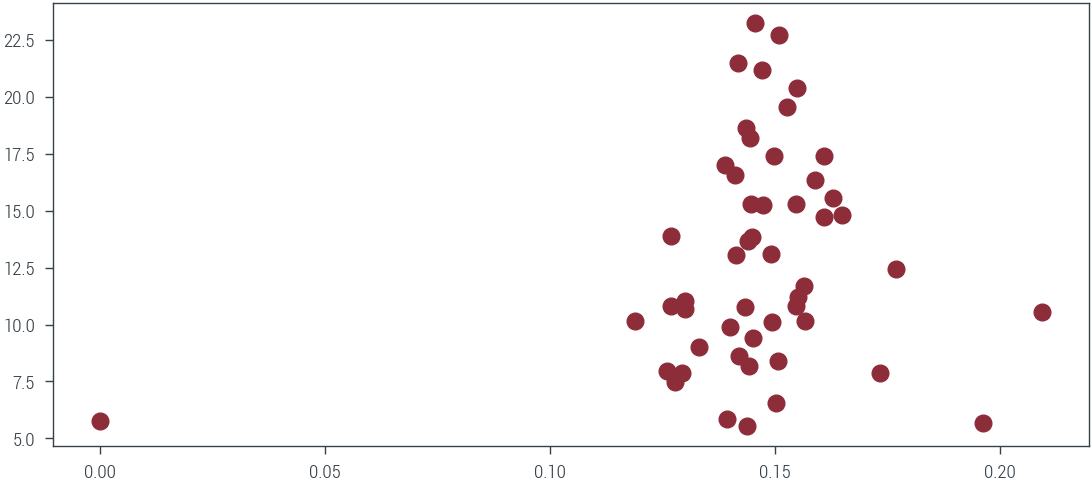

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

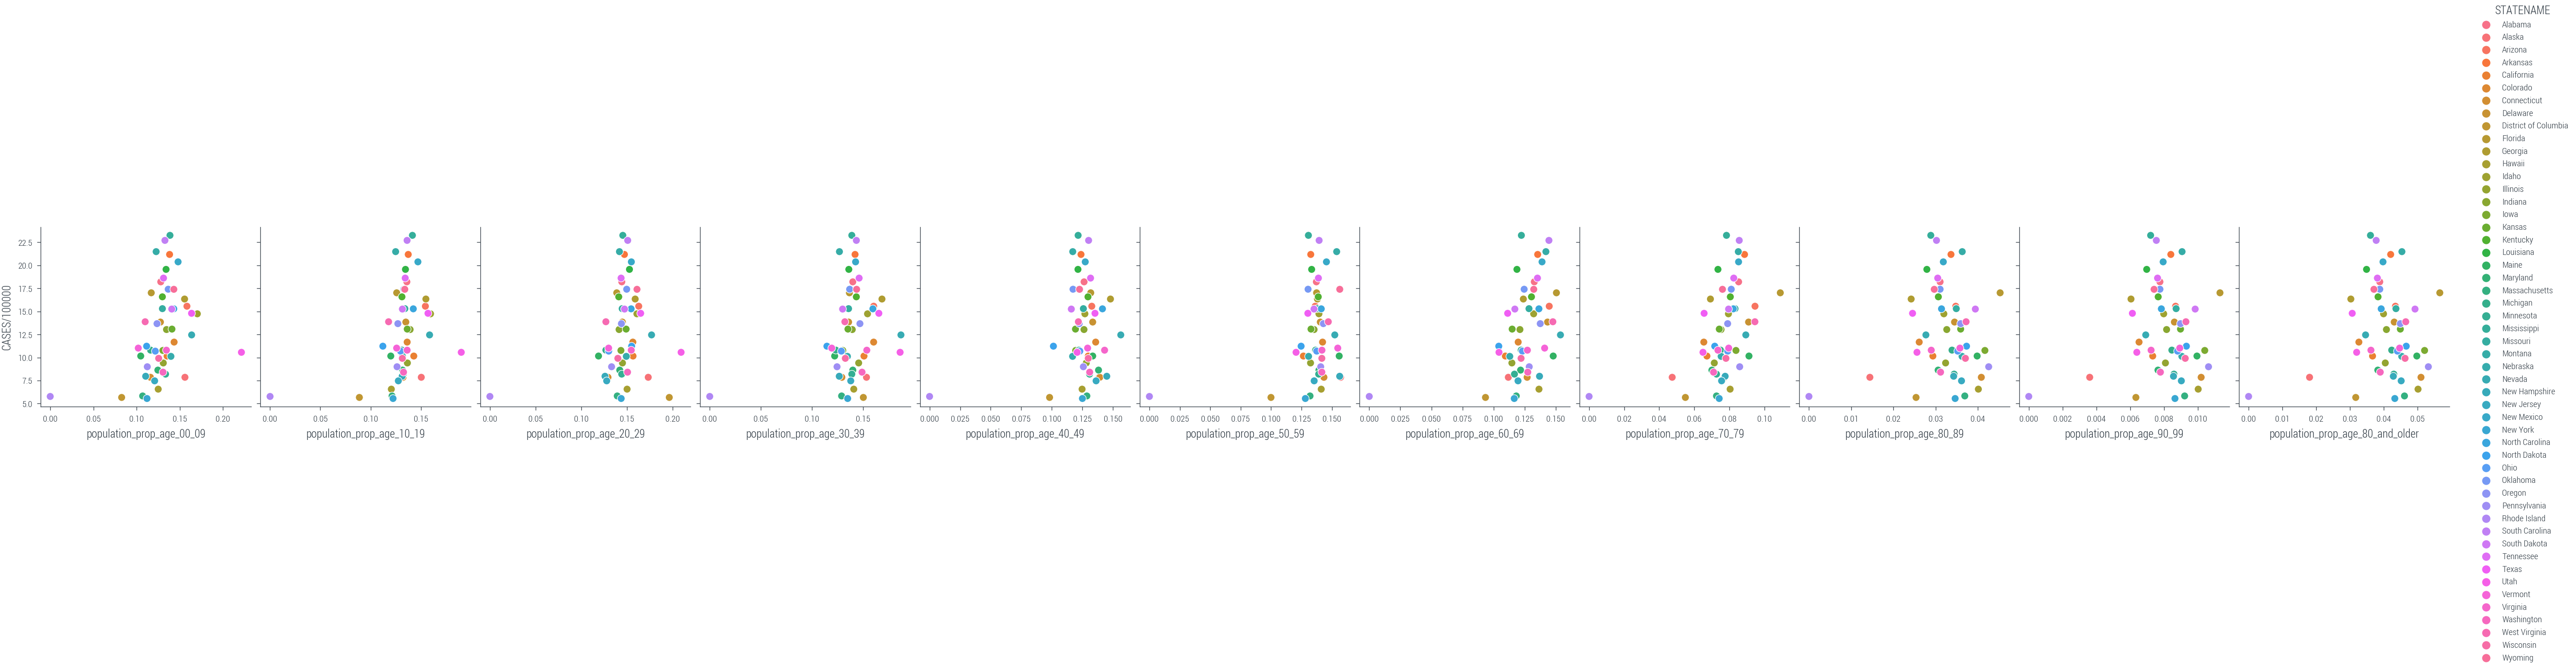

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

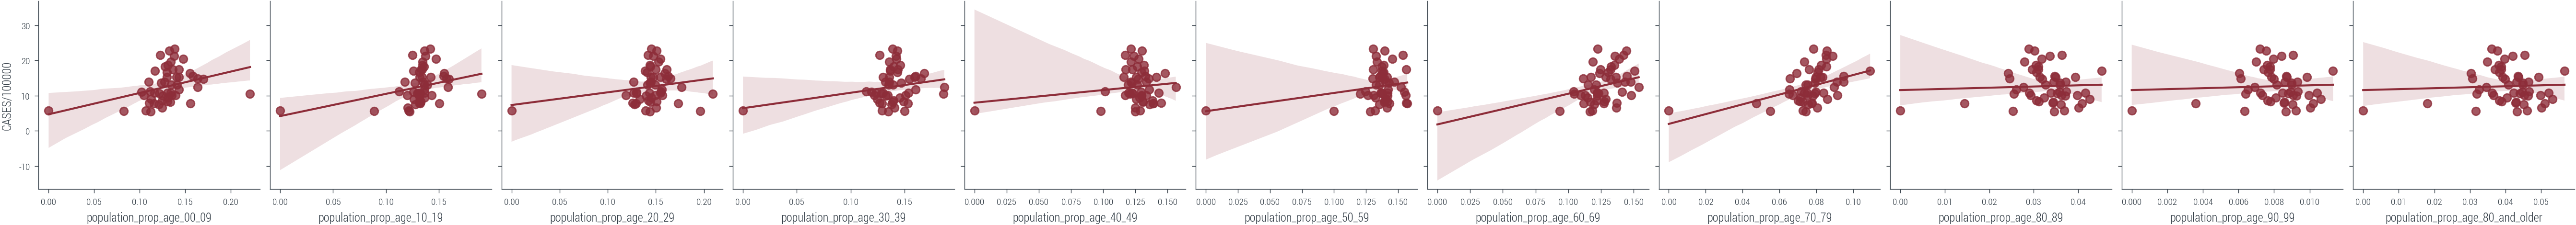

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

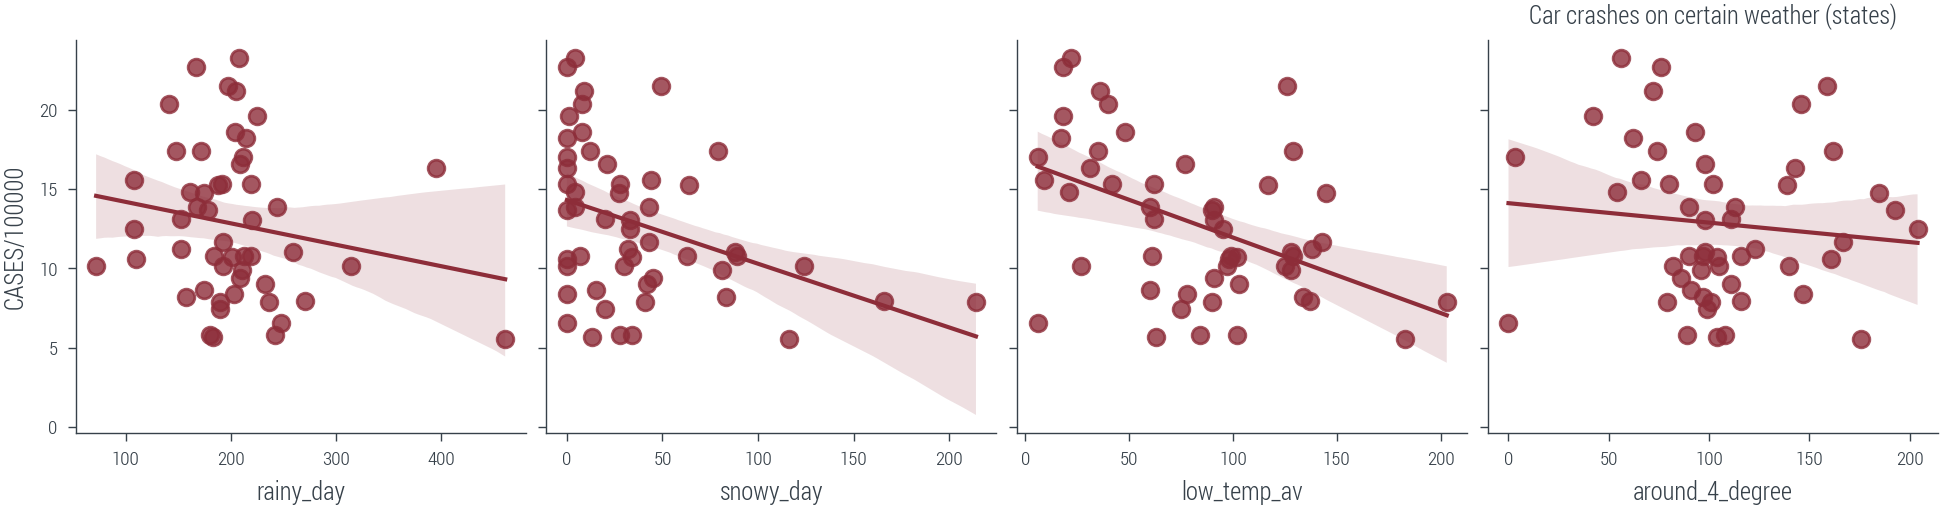

/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/jonathan/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1102.36x496.063 with 0 Axes>

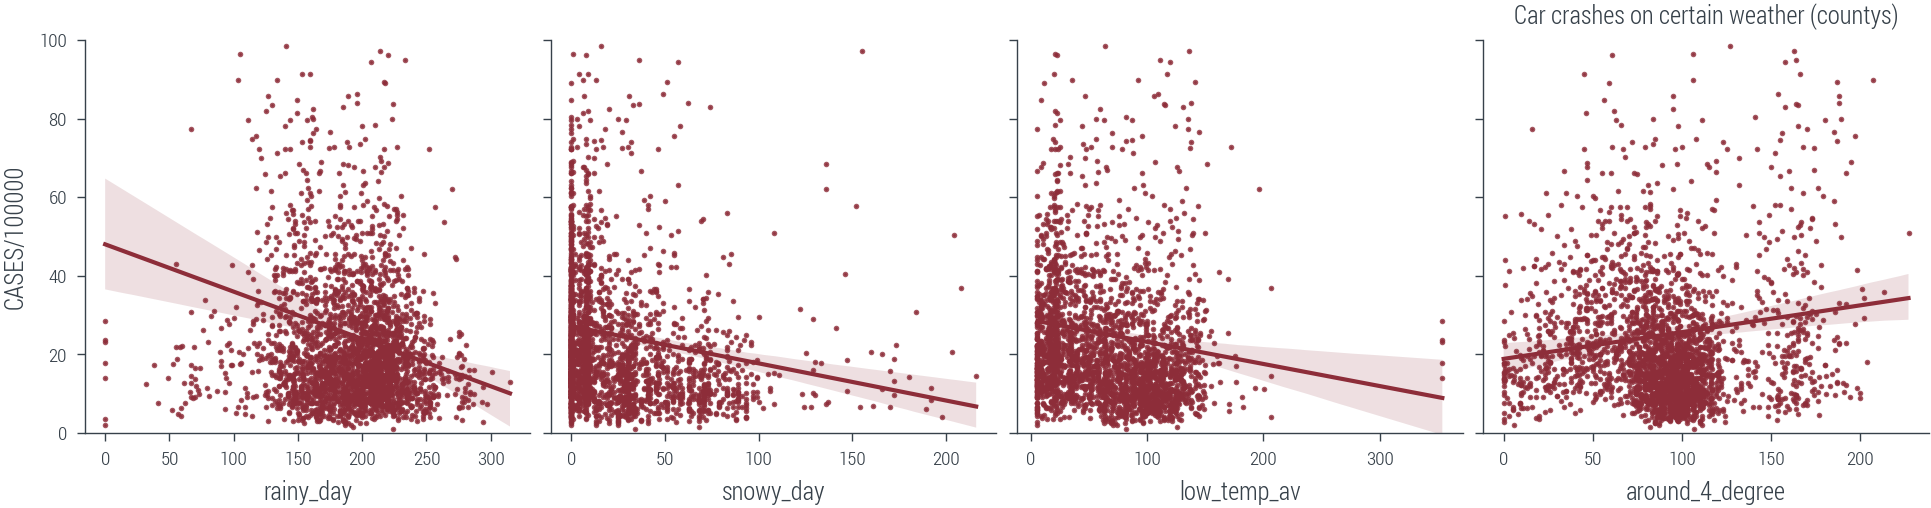

(51, 11)
(1, 51)
[[1.         0.99787378 0.995556   0.99727279 0.99009581 0.98388194
  0.96838836 0.94507037 0.92472876 0.92472828 0.92472872 0.93878349]
 [0.99787378 1.         0.99867701 0.99902213 0.99600791 0.99193238
  0.97824982 0.95771574 0.94300564 0.94300521 0.94300561 0.93330694]
 [0.995556   0.99867701 1.         0.99912633 0.99638493 0.99220339
  0.97946137 0.95973786 0.94652953 0.94652912 0.9465295  0.92674961]
 [0.99727279 0.99902213 0.99912633 1.         0.99671569 0.99175384
  0.97923192 0.95847571 0.94253274 0.94253232 0.94253271 0.93282089]
 [0.99009581 0.99600791 0.99638493 0.99671569 1.         0.99828899
  0.98999183 0.97379236 0.96323808 0.96323772 0.96323805 0.92908211]
 [0.98388194 0.99193238 0.99220339 0.99175384 0.99828899 1.
  0.99420512 0.98106093 0.97387693 0.9738766  0.9738769  0.92645996]
 [0.96838836 0.97824982 0.97946137 0.97923192 0.98999183 0.99420512
  1.         0.99539425 0.98594899 0.9859488  0.98594899 0.93841374]
 [0.94507037 0.95771574 0.959737

In [23]:
print(accidents_state[['STATENAME','CASES/100000','CASES','population']])

plt.figure()
plt.scatter(accidents_state['population_prop_age_20_29'],accidents_state['CASES/100000'])
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,hue='STATENAME')
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=population_names,kind='reg',plot_kws=dict(robust=True))#,hue='STATENAME'
plt.show()

plt.figure()
sns.pairplot(accidents_state,y_vars=['CASES/100000'],x_vars=['rainy_day','snowy_day','low_temp_av','around_4_degree'],kind='reg')
plt.title('Car crashes on certain weather (states)')
plt.show()

plt.figure()
graph = sns.pairplot(accidents_county,y_vars=['CASES/100000'],x_vars=['rainy_day','snowy_day','low_temp_av','around_4_degree'],kind='reg',plot_kws={'scatter_kws':{'s':1}})
graph.axes[0,0].set_ylim((0,100))
plt.title('Car crashes on certain weather (countys)')
plt.show()



#plt.figure()
#sns.pairplot(accidents_state,y_vars=['CASES_'])

print(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().shape)
print(accidents_state.loc[:,'CASES/100000'].to_numpy().reshape((1,-1)).shape)
corr = np.corrcoef(accidents_state.loc[:,'population_age_00_09':'population_age_80_and_older'].to_numpy().T,accidents_state.loc[:,'CASES'].to_numpy().reshape((1,-1)))
print(corr)





## List cases

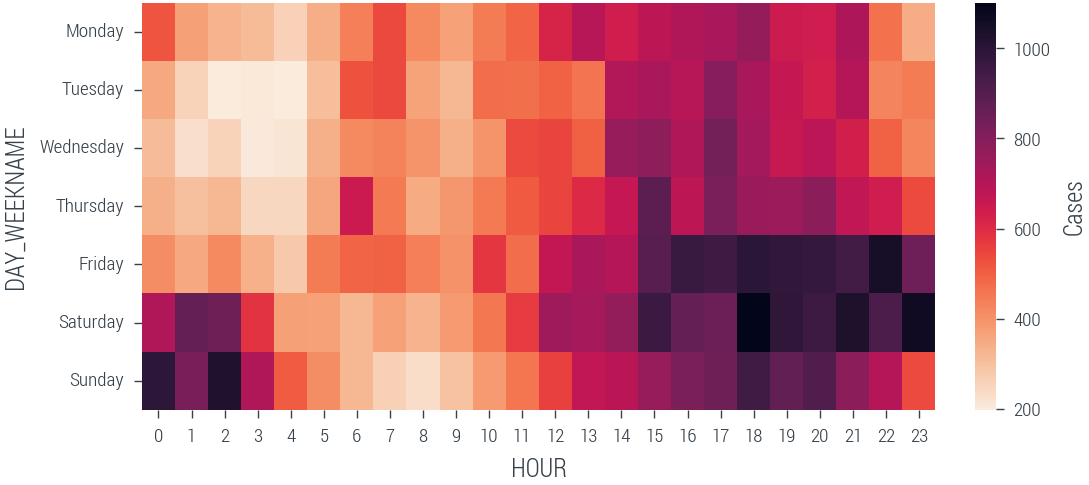

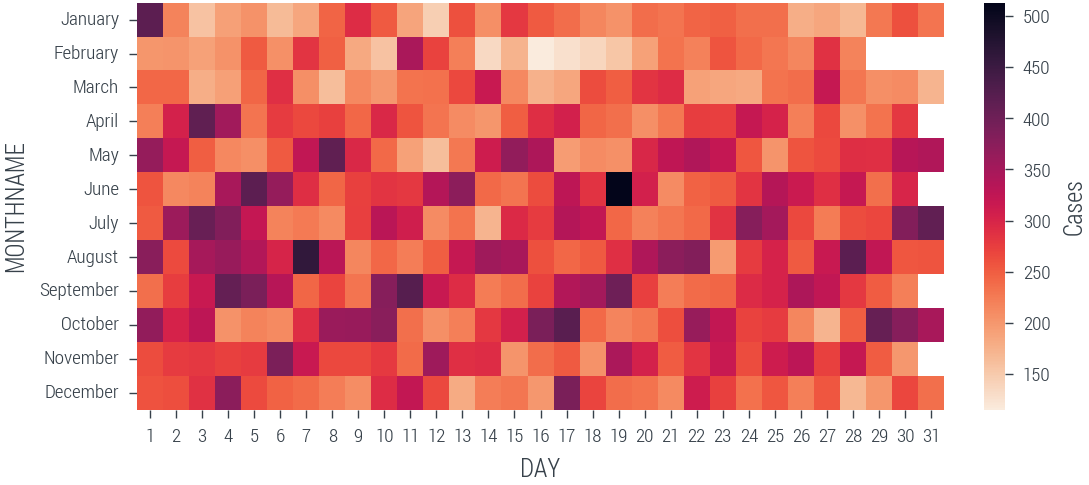

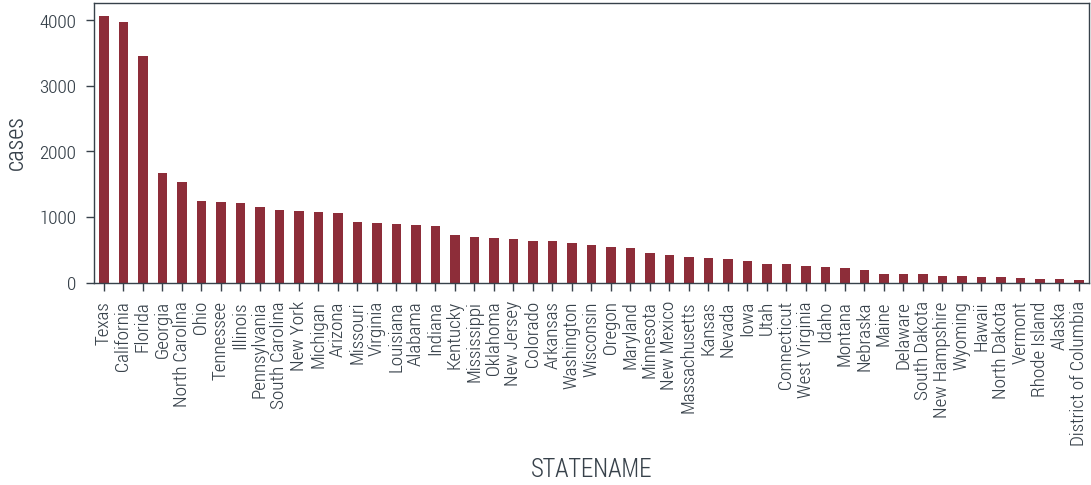

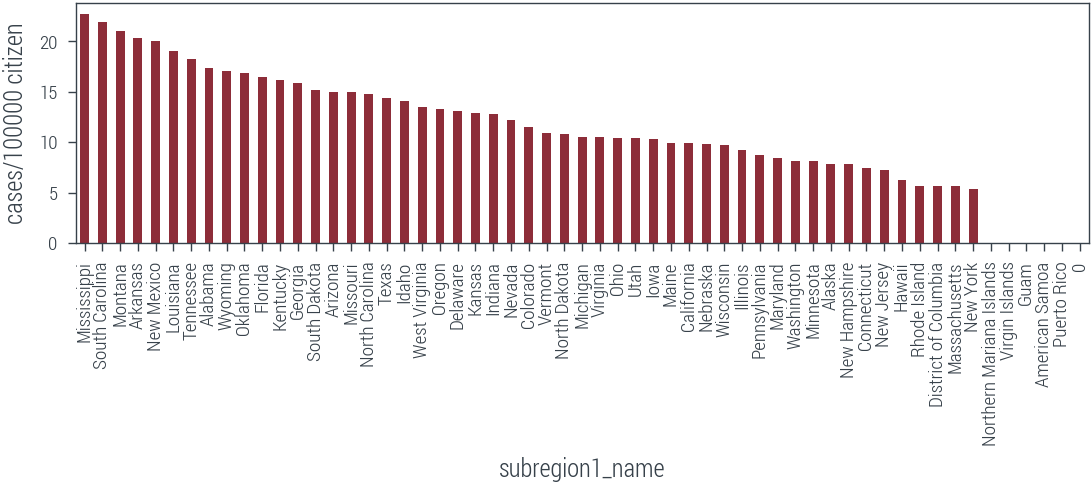

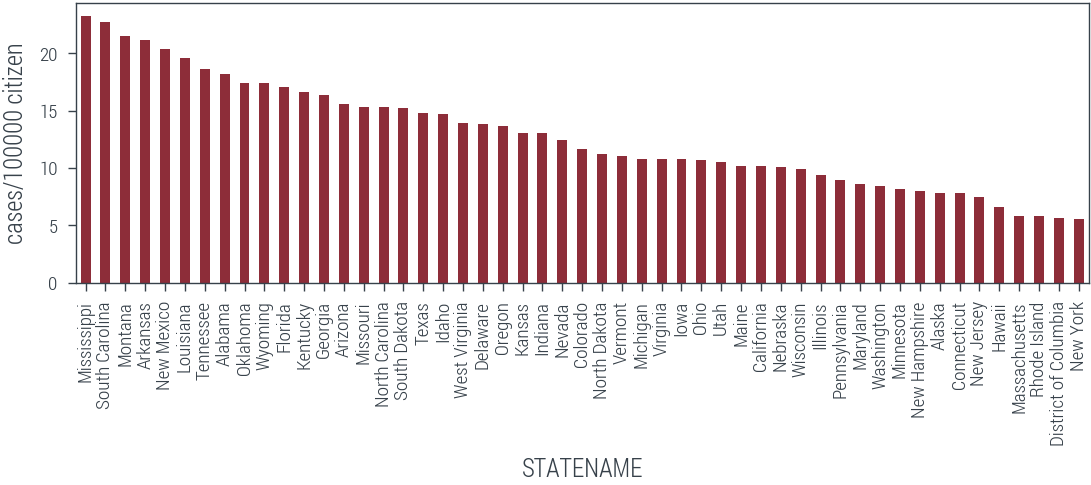

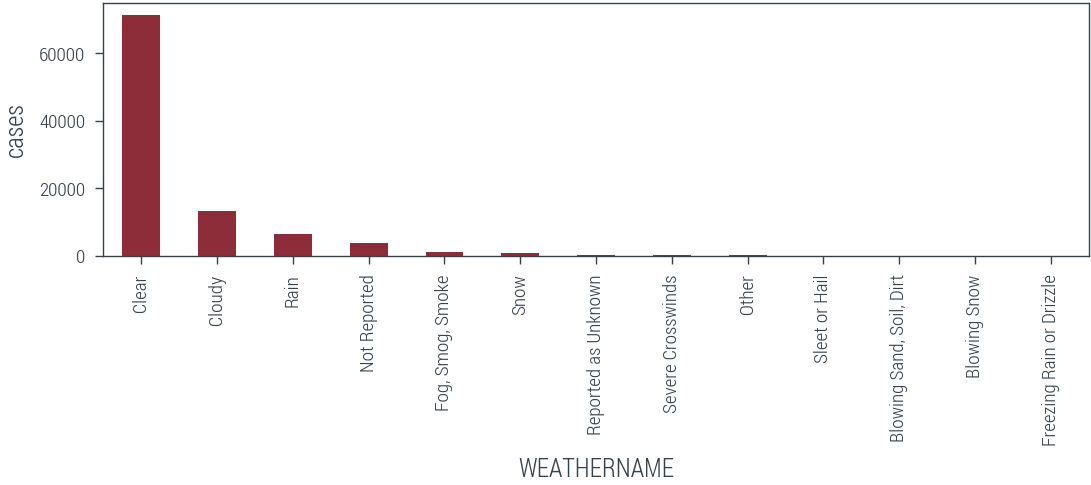

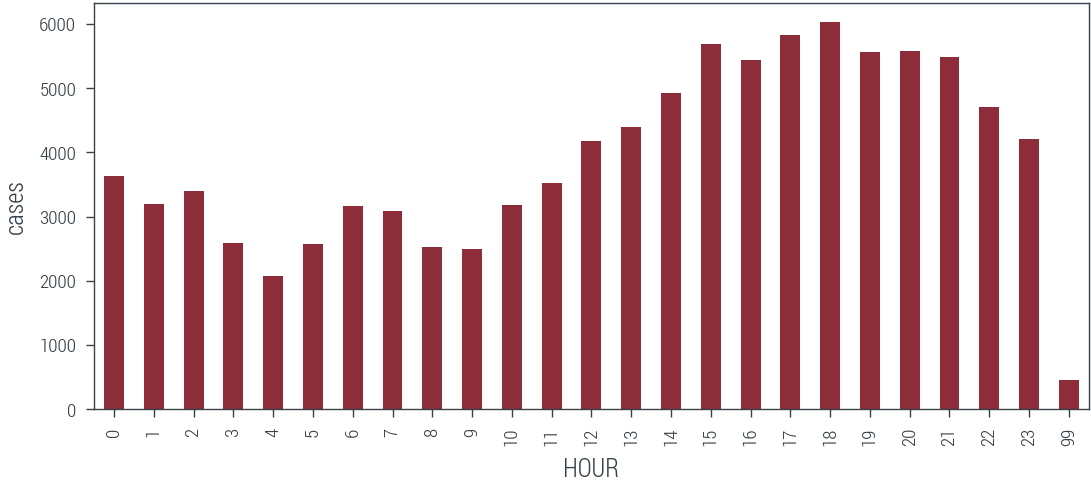

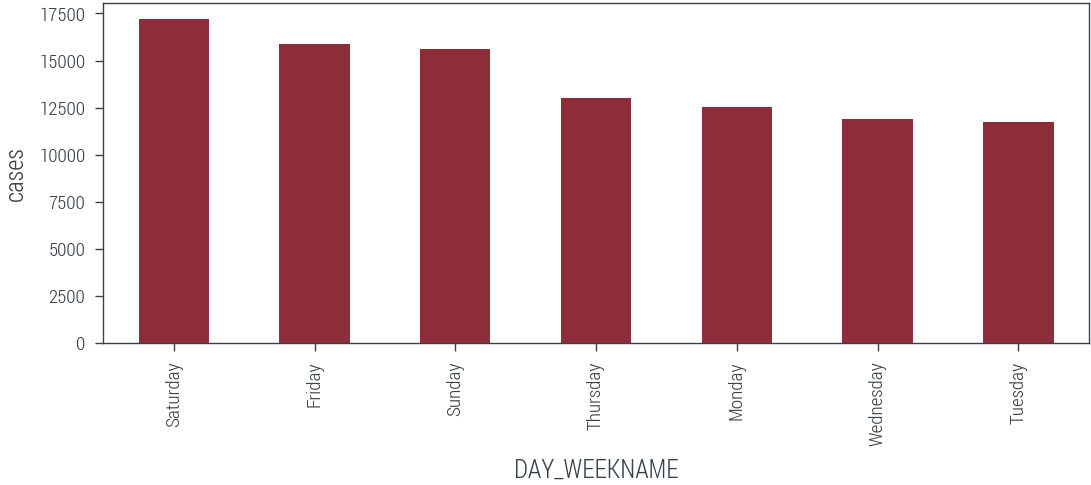

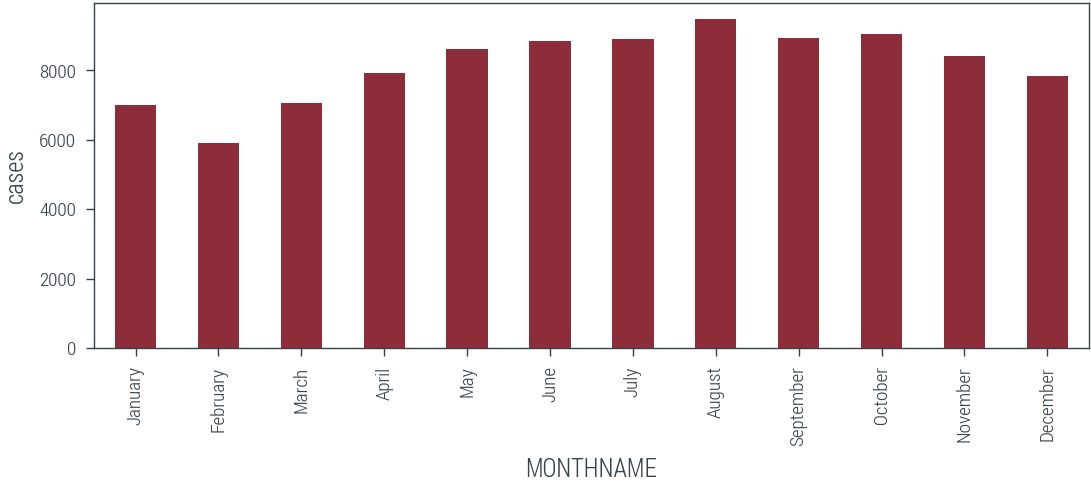

<Figure size 1102.36x496.063 with 0 Axes>

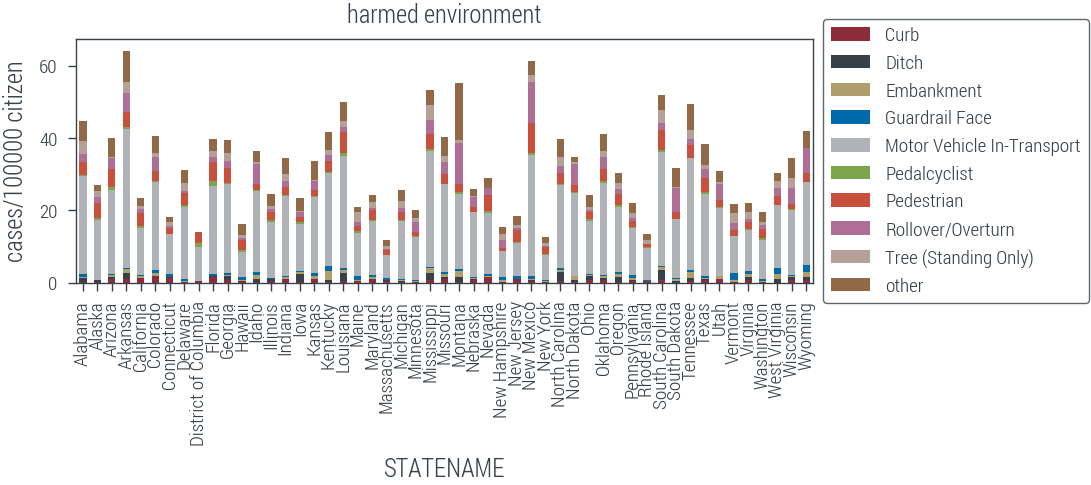

<Figure size 1102.36x496.063 with 0 Axes>

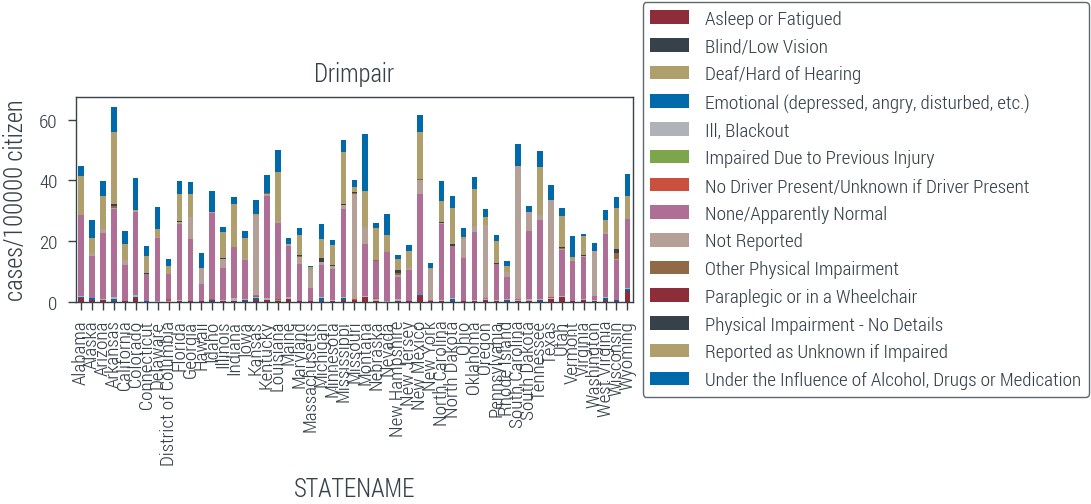

<Figure size 1102.36x496.063 with 0 Axes>

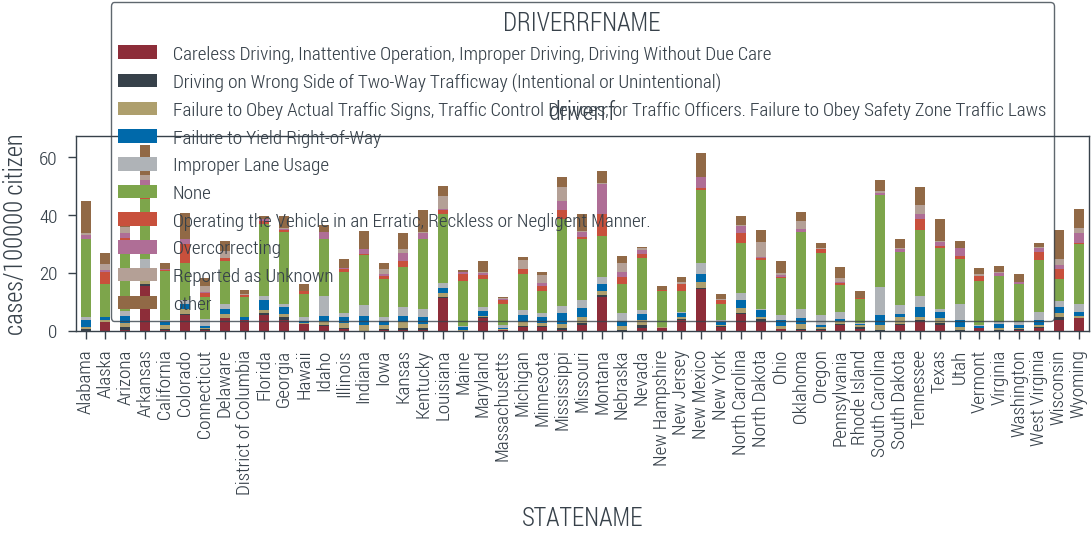

<Figure size 1102.36x496.063 with 0 Axes>

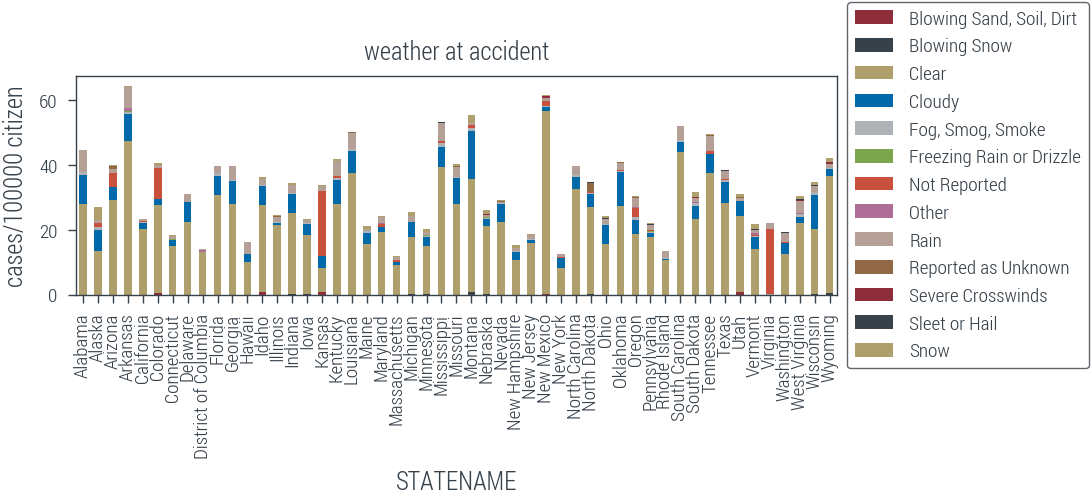

In [21]:
months = ['January','February','March','April','May','June','July','August','September','October','November','December']
days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']



plt.figure()
#plt.hist2d(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size())
sns.heatmap(accidents[accidents['HOUR']!=99].groupby(['DAY_WEEKNAME','HOUR']).size().unstack().loc[days,:],cbar_kws={'label':'Cases'},cmap=sns.cm.rocket_r)
#plt.title()
plt.show()


plt.figure()
sns.heatmap(accidents.groupby(['MONTHNAME','DAY']).size().unstack().loc[months,:],cbar_kws={'label':'Cases'},cmap=sns.cm.rocket_r)
plt.show()

plt.figure()
accidents.groupby('ST_CASE').first()['STATENAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
Google_daten.groupby(by=['subregion1_name','date']).first().groupby('subregion1_name')['CASES/100000'].sum().sort_values(ascending=False).plot(kind='bar')
#Google_daten.groupby('subregion1_name')['mobility_workspaces'].first().plot(kind='bar')
plt.ylabel('cases/100000 citizen')
plt.show()


plt.figure()
#plt.title('cases per 100000 habitants')
accidents_state.set_index('STATENAME')['CASES/100000'].sort_values(ascending=False).plot.bar()
plt.ylabel('cases/100000 citizen')
plt.show()

plt.figure()
accidents['WEATHERNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['HOUR'].value_counts().sort_index().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['DAY_WEEKNAME'].value_counts().plot.bar()
plt.ylabel('cases')
plt.show()

plt.figure()
accidents['MONTHNAME'].value_counts()[months].plot.bar()
plt.ylabel('cases')
plt.show()


accidents['HARM_EVNAME'] = accidents['HARM_EVNAME'].replace(accidents['HARM_EVNAME'].value_counts().index[10:],'other')
accidents['DRIVERRFNAME'] = accidents['DRIVERRFNAME'].replace(accidents['DRIVERRFNAME'].value_counts().index[10:],'other').fillna('None')
#labels_driverrf = [ '\n'.join(wrap(l, 20)) for l in accidents['DRIVERRFNAME'].unique()]

plt.figure()
accidents.groupby(['STATENAME','HARM_EVNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('harmed environment')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
accidents.groupby(['STATENAME','DRIMPAIRNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('Drimpair')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


plt.figure()
accidents.groupby(['STATENAME','DRIVERRFNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('driverrf')
#plt.legend(labels_driverrf,loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure()
accidents.groupby(['STATENAME','WEATHERNAME']).size().unstack().div(accidents_state.set_index('STATENAME')['population']/100000,axis=0).plot(kind='bar',stacked=True)
plt.ylabel('cases/100000 citizen')
plt.title('weather at accident')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Geo Plot


EPSG:4269
               COUNTYNAME  population  Improper Lane Usage
654           MARION (97)    950537.0                 37.0
2021       LEXINGTON (63)    290338.0                 36.0
542             COOK (31)   5200821.0                 33.0
85          MARICOPA (13)   4327184.0                 31.0
280         NEW HAVEN (9)    857748.0                 30.0
2029        RICHLAND (79)    411800.0                 29.0
2035            YORK (91)    266165.0                 28.0
181      LOS ANGELES (37)  10103711.0                 27.0
197   SAN BERNARDINO (71)   2150945.0                 26.0
1360      ST. LOUIS (189)    996227.0                 26.0
1479            CLARK (3)   2181635.0                 24.0
194        RIVERSIDE (65)   2414964.0                 24.0
2245         HARRIS (201)   4657972.0                 24.0
1955       LANCASTER (71)    541332.0                 23.0
198        SAN DIEGO (73)   3321237.0                 23.0
2017         KERSHAW (55)     65213.0         

<Figure size 1102.36x496.063 with 0 Axes>

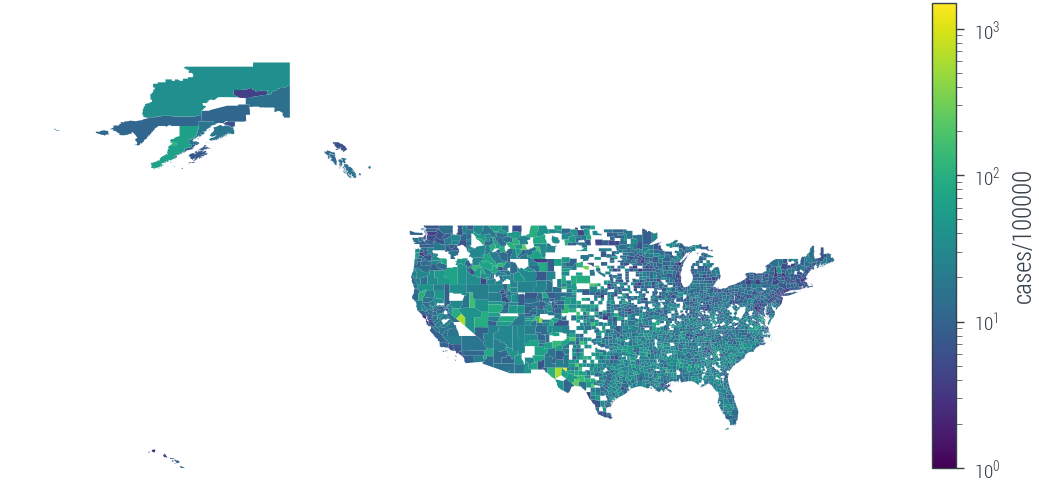

<Figure size 1102.36x496.063 with 0 Axes>

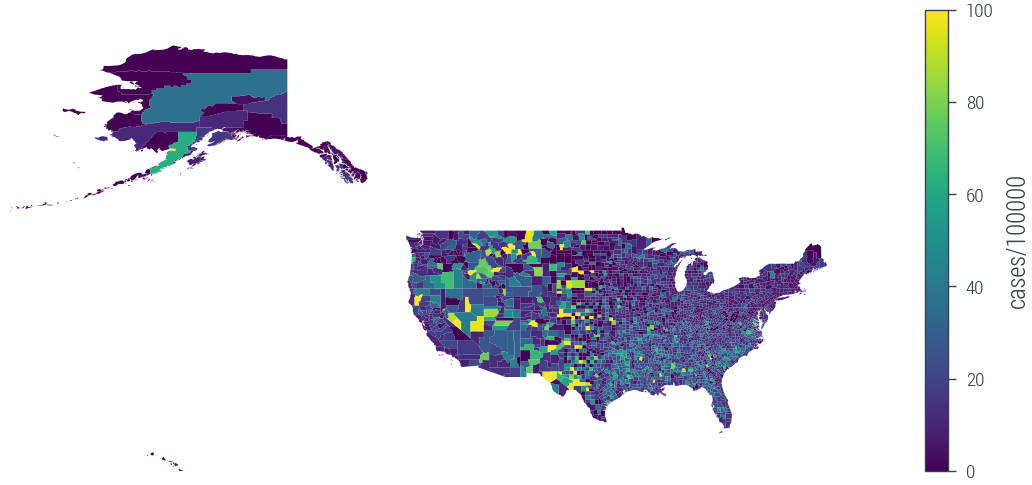

<Figure size 1102.36x496.063 with 0 Axes>

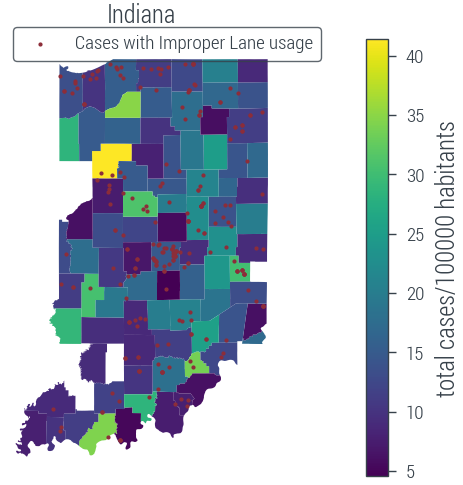

<Figure size 1102.36x496.063 with 0 Axes>

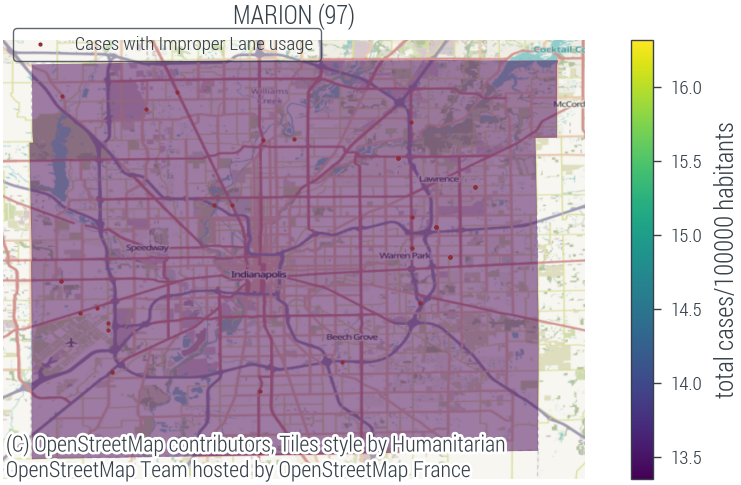

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


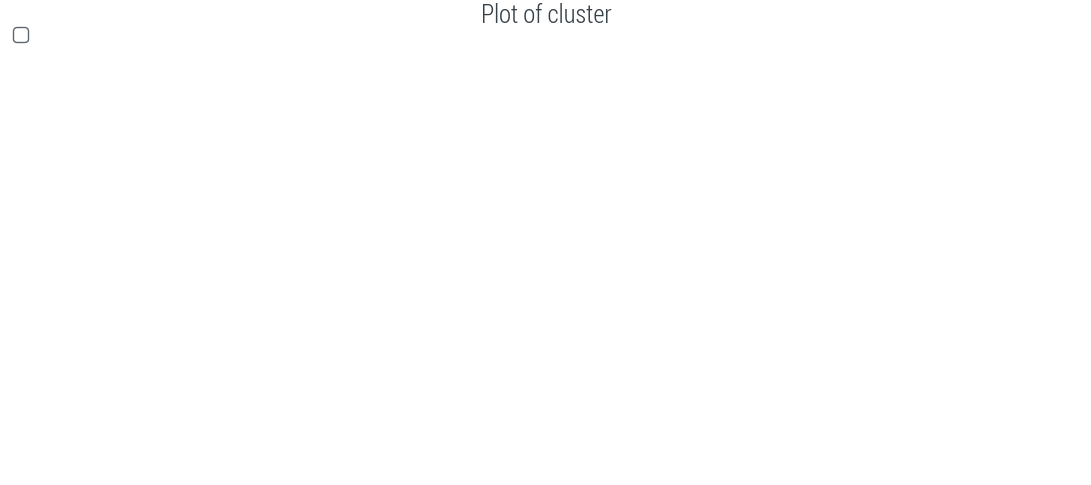

/tmp/ipykernel_3962/4265754599.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(x=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LONGITUD'],y=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LATITUDE'],s=1,label='cases with Improper Lane usage')
/tmp/ipykernel_3962/4265754599.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax.scatter(x=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LONGITUD'],y=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LATITUDE'],s=1,label='cases with Improper Lane usage')


<Figure size 1102.36x496.063 with 0 Axes>

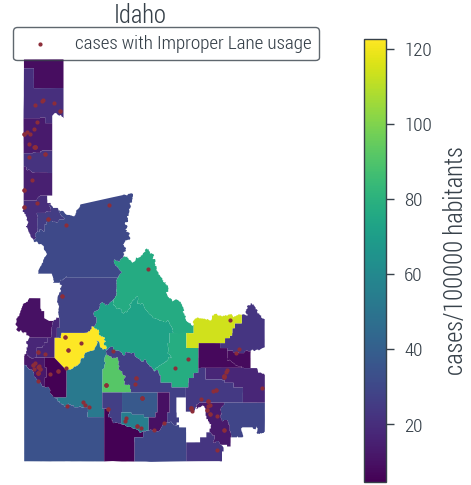

<Figure size 1102.36x496.063 with 0 Axes>

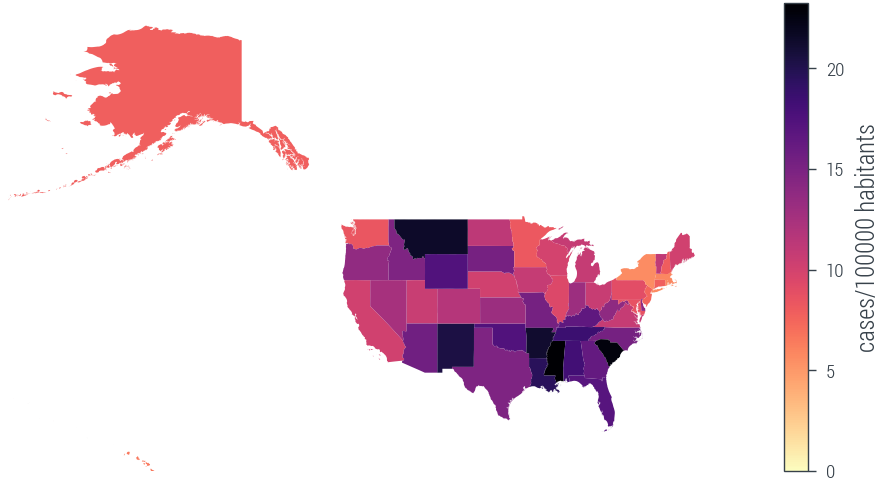

KeyError: 'cluster'

<Figure size 1102.36x496.063 with 0 Axes>

In [74]:
print(US_county_shape.crs)
print(accidents_county[['COUNTYNAME','population','Improper Lane Usage']].sort_values('Improper Lane Usage',ascending=False).head(40))
print(US_county_shape.columns)
print(accidents.columns)
print(accidents['DRIVERRF'].unique())

states_improper_lane = accidents_county.sort_values('Improper Lane Usage',ascending=False)['STATENAME'].unique()[:1]
county_improper_lane = accidents_county.sort_values('Improper Lane Usage',ascending=False)['COUNTYNAME'].unique()[:1]

plt.figure()
US_county_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000'},norm=matplotlib.colors.LogNorm(vmin=1, vmax=US_county_shape['CASES/100000'].max()))
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

plt.figure()
US_county_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000'},vmax=100)
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

for state in states_improper_lane:
    plt.figure()
    ax = US_county_shape[US_county_shape['STATENAME'] == state].plot(column='CASES/100000',legend=True,legend_kwds={'label':'total cases/100000 habitants'})
    plt.xlim(plt.gca().get_xlim())
    plt.ylim(plt.gca().get_ylim())
    ax.scatter(x=accidents[(accidents['STATENAME']==state) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LONGITUD'],y=accidents[(accidents['STATENAME']==state) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LATITUDE'],s=1,label='Cases with Improper Lane usage')
    plt.axis('off')
    plt.title(state)
    plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    plt.show()

#US_county_shape = US_county_shape.to_crs(3857)
for county in county_improper_lane:
    plt.figure()
    ax = US_county_shape[US_county_shape['COUNTYNAME'] == county].plot(column='CASES/100000',legend=True,legend_kwds={'label':'total cases/100000 habitants'},alpha=0.5)
    plt.xlim(plt.gca().get_xlim())
    plt.ylim(plt.gca().get_ylim())
    ax.scatter(x=accidents[(accidents['COUNTYNAME']==county) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LONGITUD'],y=accidents[(accidents['COUNTYNAME']==county) & (accidents['DRIVERRFNAME']=='Improper Lane Usage')]['LATITUDE'],s=1,label='Cases with Improper Lane usage')
    cx.add_basemap(ax,crs=US_county_shape.crs)
    plt.axis('off')
    plt.title(county)
    plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    plt.show()

   
cx.add_basemap(ax,crs=US_county_shape.crs)
plt.axis('off')
plt.title('Plot of cluster')
plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
plt.show()


plt.figure()
ax = US_county_shape[US_county_shape['STATENAME'] == 'Idaho'].plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'})
ax.scatter(x=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LONGITUD'],y=accidents[accidents['STATENAME']=='Idaho'][accidents['DRIVERRFNAME']=='Improper Lane Usage']['LATITUDE'],s=1,label='cases with Improper Lane usage')
plt.axis('off')
plt.title('Idaho')
plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
plt.show()

plt.figure()
US_state_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'},cmap='magma_r',vmin=0)
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

def plt_cluster(cluster_id,whole_state=True,color_cluster=True):
    plt.figure()
    if whole_state == True:
        code = accidents[accidents['cluster']==cluster_id]['subregion2_code'].unique()
        ax = US_county_shape[US_county_shape['subregion2_code'].isin(code)].plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'},alpha=0.5)
        plt.xlim(plt.gca().get_xlim())
        plt.ylim(plt.gca().get_ylim())
        if color_cluster==True:
            for i in accidents[accidents['subregion2_code'].isin(code)]['cluster'].unique():
                if i == -1:
                    label = 'not clustered accident'
                elif i == cluster_id:
                    label = 'Accident cluster (id='+str(i)+')'
                ax.scatter(x=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==i)]['LONGITUD'],y=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==i)]['LATITUDE'],s=1,label=label)
        else:
            ax.scatter(x=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==-1)]['LONGITUD'],y=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==-1)]['LATITUDE'],s=1,label='accidents')
            ax.scatter(x=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==cluster_id)]['LONGITUD'],y=accidents[(accidents['subregion2_code'].isin(code)) & (accidents['cluster']==cluster_id)]['LATITUDE'],s=1,label='cluster (id='+str(cluster_id)+')')
    else:
        latitude_min = accidents[accidents['cluster']==cluster_id]['LATITUDE'].min()
        latitude_max = accidents[accidents['cluster']==cluster_id]['LATITUDE'].max()
        longitud_min = accidents[accidents['cluster']==cluster_id]['LONGITUD'].min()
        longitud_max = accidents[accidents['cluster']==cluster_id]['LONGITUD'].max()
        epsilon = 1e-4
        temp = accidents[(accidents['LATITUDE']>latitude_min-epsilon) & (accidents['LATITUDE']<latitude_max+epsilon) & (accidents['LONGITUD']>longitud_min-epsilon) & (accidents['LONGITUD']<longitud_max+epsilon)]
        fig, ax = plt.subplots()
        ax.scatter(x=temp[temp['cluster']==cluster_id]['LONGITUD'],y=temp[temp['cluster']==cluster_id]['LATITUDE'],s=1,label='cluster (id='+str(cluster_id)+')')
        plt.xlim(plt.gca().get_xlim())
        plt.ylim(plt.gca().get_ylim())
        if color_cluster==True:
            for i in temp[temp['cluster']!=cluster_id]['cluster'].unique():
                if i == -1:
                    label = 'not clustered accident'
                else:
                    label = 'Accident cluster (id='+str(i)+')'
                ax.scatter(x=temp[temp['cluster']==i]['LONGITUD'],y=temp[temp['cluster']==i]['LATITUDE'],s=1,label=label)
        else:
            ax.scatter(x=temp[temp['cluster']!=cluster_id]['LONGITUD'],y=temp[temp['cluster']!=cluster_id]['LATITUDE'],s=1,label='accidents')
    cx.add_basemap(ax,crs=US_county_shape.crs)
    plt.axis('off')
    plt.legend(loc='upper left',bbox_to_anchor=(0, 1.05))
    return
cluster_id = 32
plt_cluster(36,True)



Human error plots 


Index(['STATEFP', 'STATENS', 'AFFGEOID', 'GEOID', 'STUSPS', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry', 'STATENAME', 'STATE', 'CASES',
       'population', 'population_density', 'area', 'latitude', 'longitude',
       'population_age_00_09', 'population_age_10_19', 'population_age_20_29',
       'population_age_30_39', 'population_age_40_49', 'population_age_50_59',
       'population_age_60_69', 'population_age_70_79', 'population_age_80_89',
       'population_age_90_99', 'population_age_80_and_older',
       'population_prop_age_00_09', 'population_prop_age_10_19',
       'population_prop_age_20_29', 'population_prop_age_30_39',
       'population_prop_age_40_49', 'population_prop_age_50_59',
       'population_prop_age_60_69', 'population_prop_age_70_79',
       'population_prop_age_80_89', 'population_prop_age_90_99',
       'population_prop_age_80_and_older', 'rainy_day', 'snowy_day',
       'low_temp_av', 'low_temp_min', 'low_temp_max', 'around_4_degree',
       'CASES

<Figure size 1102.36x496.063 with 0 Axes>

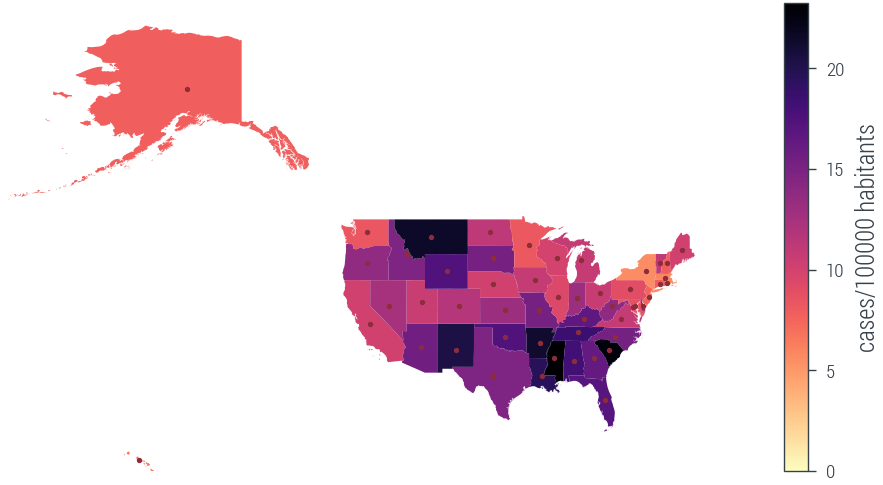

In [41]:
# pie chart geoplot
print(US_state_shape.columns)
#print(US_county_shape.loc[0,'geometry'])

plt.figure()
US_state_shape.plot(column='CASES/100000',legend=True,legend_kwds={'label':'cases/100000 habitants'},cmap='magma_r',vmin=0)
plt.scatter(US_state_shape['longitude'],US_state_shape['latitude'],s=2)
plt.xlim(-180,-60)
plt.ylim(20,None)
plt.axis('off')
plt.show()

In [1]:
### geo plot of all accidents, not too interesting. not made good looking whatsoever


## Better visibility
accidents = accidents.loc[accidents['LONGITUD'] <= 200] ##Redundant after preprocessing
accidents = accidents.loc[accidents['STATENAME'] != 'Hawaii']
accidents = accidents.loc[accidents['STATENAME'] != 'Alaska']

''' Plot accidents on map '''
crs = {'init':'epsg:4326'}
geometry = [Point(xy) for xy in zip(accidents['LONGITUD'], accidents['LATITUDE'])]
geo_data = gpd.GeoDataFrame(accidents,crs=crs,geometry=geometry)

## TODO improve plot
geo_data.plot(geo_data['STATE'],figsize=(25,25))




NameError: name 'accidents' is not defined

In [ ]:
## TODO optimize code, make plot nice.

## Data is calculated
pop_val = state_pop['POPESTIMATE2021'].values
statenames = state_pop['NAME'].values
counts = []
## For every state count amount of accidents.
# TODO remove non unique ids. (maybe, depending on what we want)
for x in statenames:
    counts.append(accidents['STATENAME'].value_counts()[x])    
state_pop.insert(2,'Accidents/State',counts,True)
state_pop.insert(3,'Lane Miles',states,True)
## res is the value we wanted to calculate
res = np.array(counts) / ( states * pop_val )
b = np.sort(res) ## We want to rescale the map accordingly
state_pop.insert(4,'AccidentsPerCapitaPerLaneMile',res,True)
state_pop.rename(columns = {'NAME':'STATENAME'}, inplace = True) 

### Plot
US_state_shape = save_US.copy()
US_state_shape = geopandas.GeoDataFrame(pd.merge(US_state_shape,state_pop, on=['STATENAME']))

US_state_shape.plot(column='AccidentsPerCapitaPerLaneMile',vmin=b[0],vmax=b[-3])
plt.xlim(-180,-60)
plt.ylim(20,None)

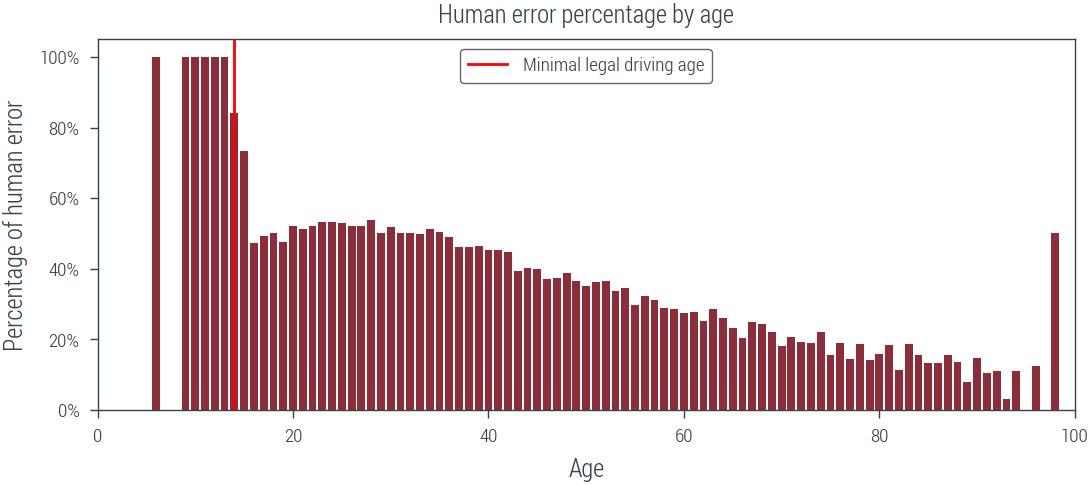

AGE
6     1.000000
9     1.000000
10    1.000000
11    1.000000
12    1.000000
13    1.000000
14    0.841270
15    0.733333
16    0.471631
17    0.493292
18    0.500726
19    0.476349
20    0.520706
21    0.512789
Name: count, dtype: float64


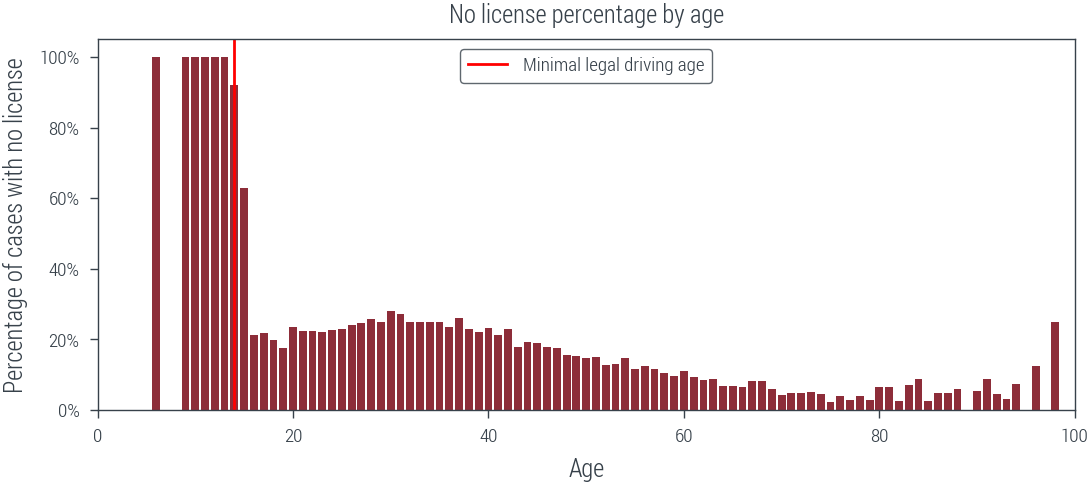

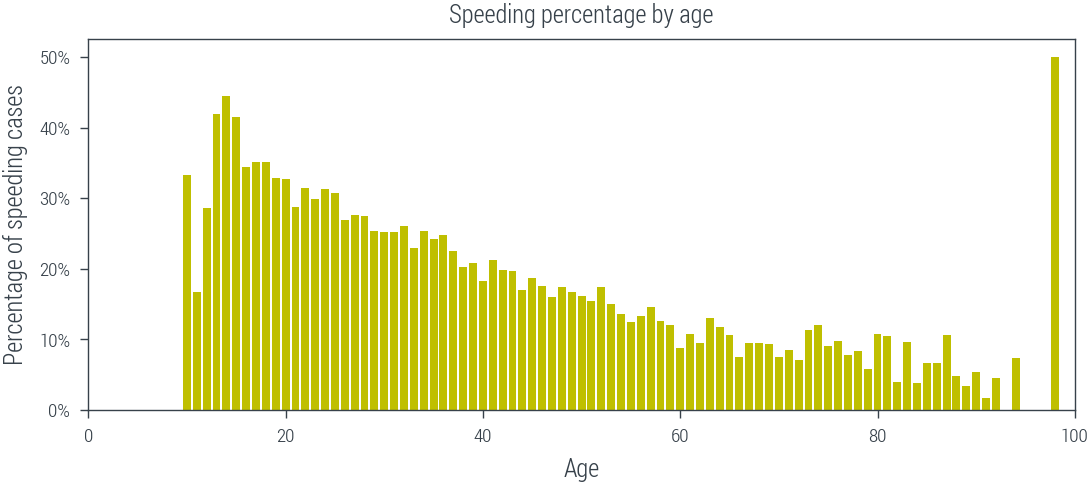

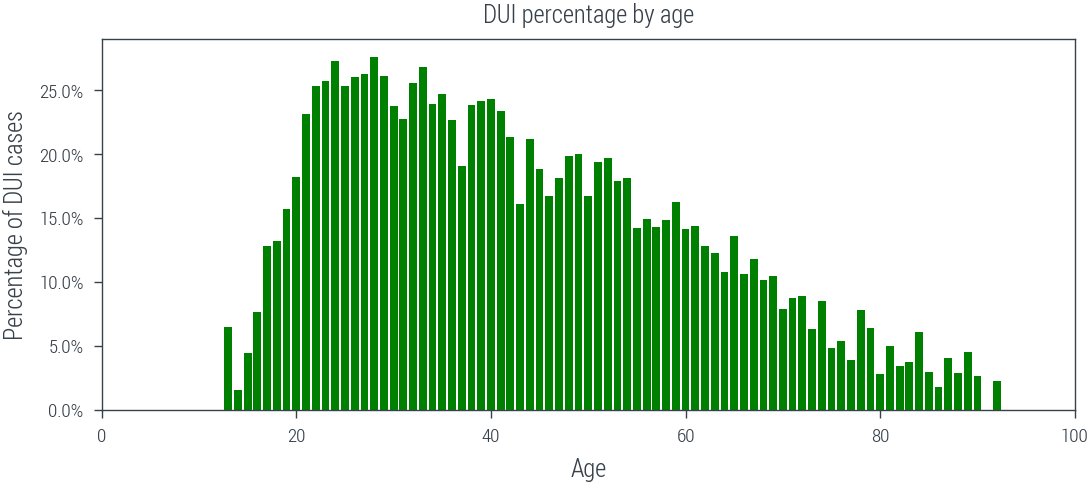

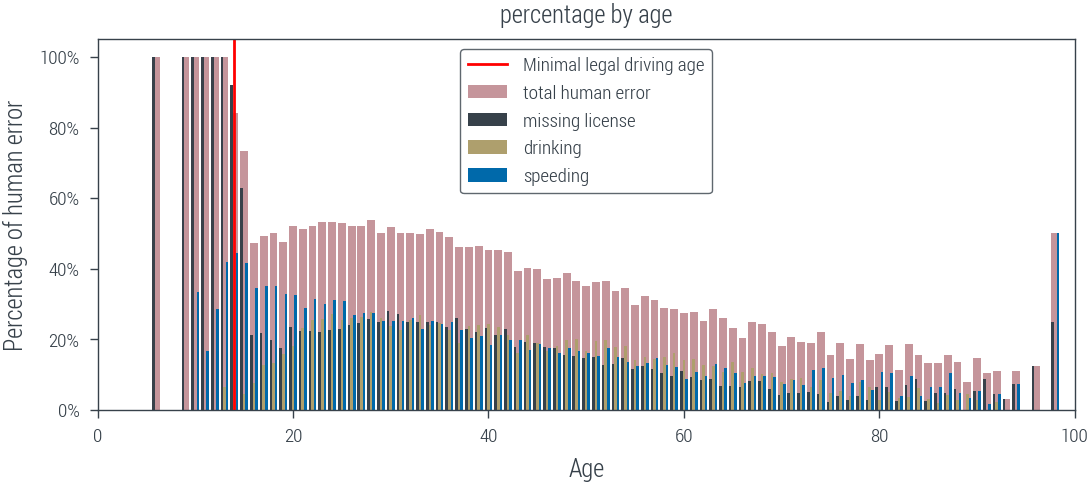

5006
7348
7348


In [12]:
### plot with age 
quot = drivers[drivers['human_error']==1].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)

ax = plt.subplot()
ax.bar(quot.keys(),quot.values*100)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
plt.title('Human error percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of human error')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.legend()
plt.show()

### Print calculated arrays as sanity check
print(quot.head(14)) ##thats great news, at 14 you can legally get your license in some states. Under 14, everything is classified as human error.

### Portion of revoked license 


quot_license = drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7,9]))].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)
ax = plt.subplot()
ax.bar(quot_license.keys(),quot_license.values*100)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
plt.title('No license percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of cases with no license')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.legend()
plt.show()

###Speeding 

quot_speeding = drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)
ax = plt.subplot()
ax.bar(quot_speeding.keys(),quot_speeding.values*100,color='y')
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
plt.title('Speeding percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of speeding cases')
plt.show()

### Alcohol

quot_alcohol = drivers[drivers["DR_DRINK"]==1].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)
ax = plt.subplot()
ax.bar(quot_alcohol.keys(),quot_alcohol.values*100,color='g')
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
plt.title('DUI percentage by age')
plt.xlabel('Age')
plt.ylabel('Percentage of DUI cases')
plt.show()


#multiplot 
width = 0.8/3
ax = plt.subplot()
ax.bar(quot.keys(),quot.values*100,alpha=0.5,label='total human error')
ax.bar(quot_license.keys()-width,quot_license.values*100,width=width,label='missing license')
ax.bar(quot_alcohol.keys(),quot_alcohol.values*100,width=width,label='drinking')
ax.bar(quot_speeding.keys()+width,quot_speeding.values*100,width=width,label='speeding')
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
plt.title('different human errors')
plt.xlabel('Age')
plt.ylabel('Percentage of human error')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.legend()
plt.show()

### Check for duplicate causes

print(len(drivers[(drivers['DR_DRINK'] == 1) & (drivers['SPEEDREL'].isin([2,3,4,5,8]))]))
print(len(drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7,9])) & (drivers['SPEEDREL'].isin([2,3,4,5,8]))]))
print(len(drivers[(drivers['L_TYPE']==0) | (drivers['L_STATUS'].isin([0,1,2,3,4,7,9])) & (drivers['DR_DRINK']==1)]))

## TODO Think about what to do for duplicate causes, plot stacked bar plot. 



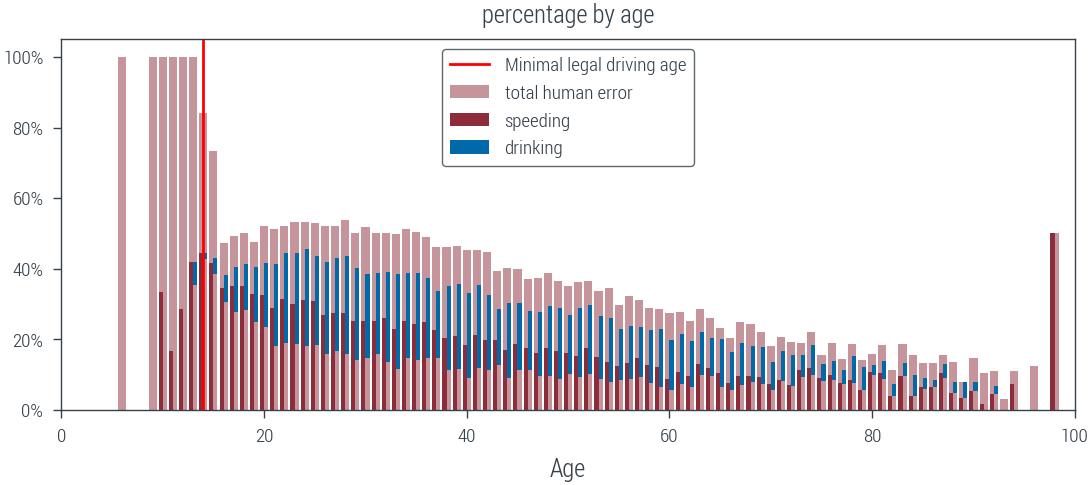

In [29]:
## Stacking plot
# How to read the plot:
# overlapping means multiple human errors
quot = drivers[drivers['human_error']==1].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)
quot_speeding = drivers[drivers['SPEEDREL'].isin([2,3,4,5,8])].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)
quot_alcohol = drivers[drivers["DR_DRINK"]==1].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)
quot_speeding_without_alcohol = drivers[(drivers['SPEEDREL'].isin([2,3,4,5,8])) & (drivers["DR_DRINK"]!=1)].value_counts('AGE',sort=False)/drivers.value_counts('AGE',sort=False)



width = 0.4
ax = plt.subplot()
ax.bar(quot.keys(),quot.values*100,alpha=0.5,label='total human error')
ax.bar(quot_speeding.keys()-width/2,quot_speeding.values*100,width=width,label='speeding',color=rgb.tue_red)
ax.bar(quot_alcohol.keys()+width/2,quot_alcohol.values*100,bottom=quot_speeding_without_alcohol.values*100,width=width,label='drinking',color=rgb.tue_blue)
ax.yaxis.set_major_formatter(tck.PercentFormatter())
plt.xlim(0,100)
plt.title('percentage by age')
plt.xlabel('Age')
plt.ylabel('percentage of human error')
plt.axvline(x=14, color='r', linestyle='-',label='Minimal legal driving age')
plt.legend()
plt.show()